Linear Programming Assignment
WeBWorK Question Using Python
Consider WW Set 03 Problem 3. Using python, 

Problem:
  x + y >= 7
  2x + y >= 12
  x >= 0, y >= 0
Objective: P = 3x + 2y

All intersections of boundary equalities (before feasibility check):
  ('L1', 'L2'): (5.0, 2.0)
  ('L1', 'X0'): (0.0, 7.0)
  ('L1', 'Y0'): (7.0, 0.0)
  ('L2', 'X0'): (0.0, 12.0)
  ('L2', 'Y0'): (6.0, 0.0)
  ('X0', 'Y0'): (0.0, 0.0)

Feasible corner points (vertices), sorted by x then y:
  Vertex 1: (0.0, 12.0)
  Vertex 2: (5.0, 2.0)
  Vertex 3: (7.0, 0.0)

Objective values at each feasible corner:
  (0.0, 12.0) -> P = 24.0
  (5.0, 2.0) -> P = 19.0
  (7.0, 0.0) -> P = 21.0

Maximum P among corners: P = 24.0 at point (0.0, 12.0)

Surplus variables (s1, s2) at each corner:
  Point (0.0, 12.0): s1 = 5.0, s2 = 0.0
  Point (5.0, 2.0): s1 = 0.0, s2 = 0.0
  Point (7.0, 0.0): s1 = 0.0, s2 = 2.0

linprog result check:
  Solver failed: The problem is unbounded. (HiGHS Status 10: model_status is Unbounded; primal_status is At upper bound)


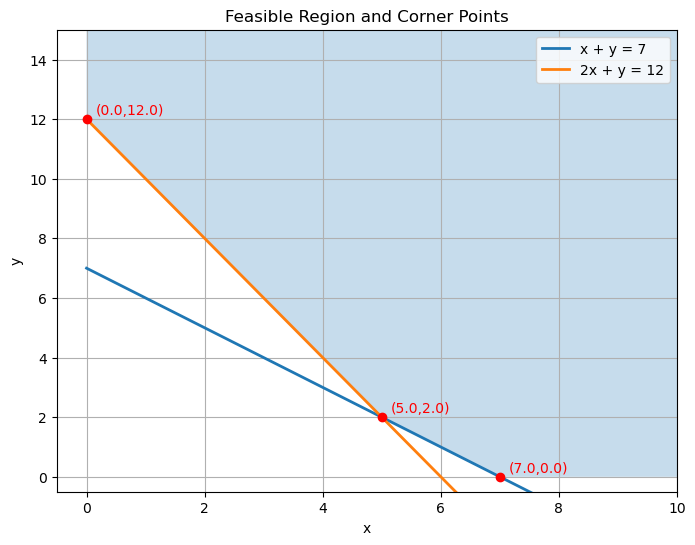

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.optimize import linprog

# Problem statement
print("Problem:")
print("  x + y >= 7")
print("  2x + y >= 12")
print("  x >= 0, y >= 0")
print("Objective: P = 3x + 2y\n")

# Function to find intersection of two lines a1*x + b1*y = c1, a2*x + b2*y = c2
def intersect(a1, b1, c1, a2, b2, c2):
    A = np.array([[a1, b1], [a2, b2]], dtype=float)
    C = np.array([c1, c2], dtype=float)
    try:
        sol = np.linalg.solve(A, C)
        return (float(sol[0]), float(sol[1]))
    except np.linalg.LinAlgError:
        return None

# Equations in the form a*x + b*y = c
eqs = {
    "L1": (1, 1, 7),     # x + y = 7
    "L2": (2, 1, 12),    # 2x + y = 12
    "X0": (1, 0, 0),     # x = 0
    "Y0": (0, 1, 0)      # y = 0
}

# Compute all pairwise intersections
pairs = list(combinations(eqs.keys(), 2))
intersections = {}
for p in pairs:
    sol = intersect(*eqs[p[0]], *eqs[p[1]])
    if sol is not None:
        intersections[p] = sol

print("All intersections of boundary equalities (before feasibility check):")
for k, v in intersections.items():
    print(f"  {k}: {v}")
print()

# Check feasibility
def is_feasible(x, y):
    eps = 1e-9
    return (x >= -eps) and (y >= -eps) and (x + y >= 7 - eps) and (2*x + y >= 12 - eps)

feasible_points = []
for v in intersections.values():
    x, y = v
    if is_feasible(x, y):
        x_r = 0.0 if abs(x) < 1e-9 else round(x, 10)
        y_r = 0.0 if abs(y) < 1e-9 else round(y, 10)
        feasible_points.append((x_r, y_r))

# Remove duplicates and sort
feasible_points = sorted(list(set(feasible_points)), key=lambda p: (p[0], p[1]))
print("Feasible corner points (vertices), sorted by x then y:")
for i, (x, y) in enumerate(feasible_points, 1):
    print(f"  Vertex {i}: ({x}, {y})")
print()

# Objective function
def P(x, y): return 3*x + 2*y

print("Objective values at each feasible corner:")
best = None
for x, y in feasible_points:
    val = P(x, y)
    print(f"  ({x}, {y}) -> P = {val}")
    if best is None or val > best[0]:
        best = (val, (x, y))

print()
print(f"Maximum P among corners: P = {best[0]} at point {best[1]}\n")

# Surplus variables
print("Surplus variables (s1, s2) at each corner:")
for x, y in feasible_points:
    s1 = x + y - 7
    s2 = 2*x + y - 12
    print(f"  Point ({x}, {y}): s1 = {s1}, s2 = {s2}")
print()

# Solve using linprog
c = [-3, -2]  # maximize P = 3x + 2y → minimize -P
A_ub = [[-1, -1], [-2, -1]]  # inequalities as <= form
b_ub = [-7, -12]
bounds = [(0, None), (0, None)]

res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method="highs")
print("linprog result check:")
if res.success:
    x_opt, y_opt = res.x
    print(f"  Optimal (from solver): x = {x_opt:.6f}, y = {y_opt:.6f}")
    print(f"  Maximum P (from solver) = {-res.fun:.6f}")
else:
    print("  Solver failed:", res.message)

# Plot feasible region
x_vals = np.linspace(0, 10, 400)
y1 = 7 - x_vals
y2 = 12 - 2*x_vals
y_bottom = np.maximum.reduce([y1, y2, np.zeros_like(x_vals)])
y_top = np.ones_like(x_vals) * 15
plt.figure(figsize=(8,6))
plt.plot(x_vals, y1, lw=2, label='x + y = 7')
plt.plot(x_vals, y2, lw=2, label='2x + y = 12')
plt.fill_between(x_vals, y_bottom, y_top, where=(y_top>y_bottom), alpha=0.25)
for (x, y) in feasible_points:
    plt.scatter(x, y, color='red', zorder=5)
    plt.text(x + 0.15, y + 0.15, f'({x},{y})', color='red')
if res.success:
    plt.scatter(res.x[0], res.x[1], color='green', marker='X', s=100, zorder=6)
    plt.text(res.x[0]+0.15, res.x[1]+0.15, 'Solver opt', color='green')
plt.xlim(-0.5, 10)
plt.ylim(-0.5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Feasible Region and Corner Points')
plt.legend()
plt.grid(True)
plt.show()


### Set 04 Problem 6 — Linear Programming Application

We want to determine how many **deluxe** and **standard** snowboards should be produced to maximize revenue.

Let:  
- \( x \) = number of deluxe snowboards  
- \( y \) = number of standard snowboards  

Each **deluxe** model requires:  
- 22 hours of labor  
- 66 units of material  

Each **standard** model requires:  
- 11 hours of labor  
- 55 units of material  

The company has:  
- 781 hours of labor available  
- 2893 units of material available  

The selling prices are:  
- Deluxe: \$306  
- Standard: \$170  

---

### Objective Function
Maximize total revenue:

\[
P = 306x + 170y
\]

### Subject to constraints
\[
\begin{cases}
22x + 11y \le 781 & \text{(labor hours)} \\
66x + 55y \le 2893 & \text{(material)} \\
x \ge 0, \, y \ge 0 & \text{(non-negativity)}
\end{cases}
\]

---

We will now use Python to:
1. Find the corner points of the feasible region,  
2. Graph the feasible set,  
3. Find which corner maximizes \( P \),  
4. Introduce slack variables, and  
5. Verify the result using a built-in Linear Programming solver.


Problem:
 Maximize R = 306 x + 170 y
 Subject to:
   22 x + 11 y <= 781   (hours)
   66 x + 55 y <= 2893  (material)
   x >= 0, y >= 0

All boundary intersections (before checking feasibility):
  ('H', 'M'): (22.99999999999999, 25.000000000000014)
  ('H', 'X0'): (0.0, 71.0)
  ('H', 'Y0'): (35.5, 0.0)
  ('M', 'X0'): (0.0, 52.6)
  ('M', 'Y0'): (43.833333333333336, 0.0)
  ('X0', 'Y0'): (0.0, 0.0)

Feasible corner points (vertices):
  Vertex 1: (0.0, 0.0)
  Vertex 2: (0.0, 52.6)
  Vertex 3: (23.0, 25.0)
  Vertex 4: (35.5, 0.0)

Revenue at each feasible corner:
  (0.0, 0.0) -> R = 0.0
  (0.0, 52.6) -> R = 8942.0
  (23.0, 25.0) -> R = 11288.0
  (35.5, 0.0) -> R = 10863.0

Maximum revenue among corner points: R = 11288.0 at point (23.0, 25.0)

Slack (unused) resources at each feasible corner:
  (0.0, 0.0): slack_hours = 781.0, slack_material = 2893.0
  (0.0, 52.6): slack_hours = 202.39999999999998, slack_material = 0.0
  (23.0, 25.0): slack_hours = 0.0, slack_material = 0.0
  (35.5, 0.0): sla

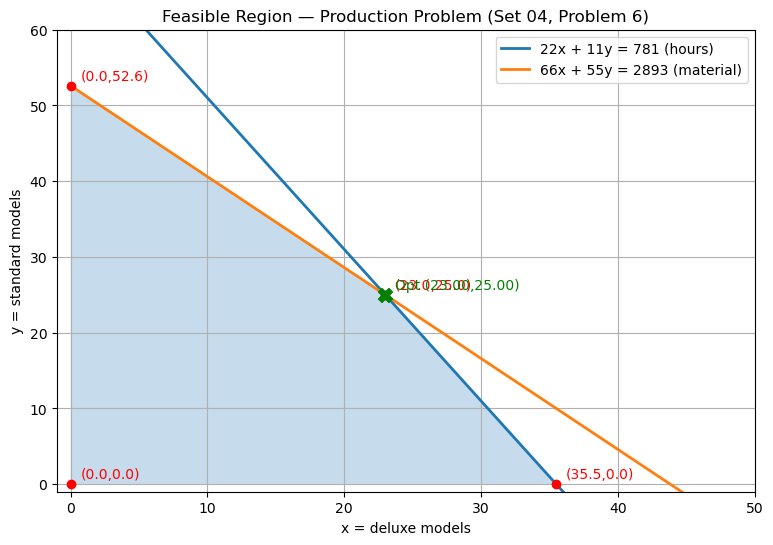

In [9]:

# Set 04 Problem 6
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.optimize import linprog

# Problem printout
print("Problem:")
print(" Maximize R = 306 x + 170 y")
print(" Subject to:")
print("   22 x + 11 y <= 781   (hours)")
print("   66 x + 55 y <= 2893  (material)")
print("   x >= 0, y >= 0\n")

#solving intersection of two lines a1*x + b1*y = c1 and a2*x + b2*y = c2
def intersect(a1, b1, c1, a2, b2, c2):
    A = np.array([[a1, b1], [a2, b2]], dtype=float)
    C = np.array([c1, c2], dtype=float)
    try:
        sol = np.linalg.solve(A, C)
        return (float(sol[0]), float(sol[1]))
    except np.linalg.LinAlgError:
        return None

# Equations (as equalities) to consider for intersections:
eqs = {
    "H": (22, 11, 781),   # hours: 22x + 11y = 781
    "M": (66, 55, 2893),  # material: 66x + 55y = 2893
    "X0": (1, 0, 0),      # x = 0
    "Y0": (0, 1, 0)       # y = 0
}

# computing all pairwise intersections
pairs = list(combinations(eqs.keys(), 2))
intersections = {}
for p in pairs:
    sol = intersect(*eqs[p[0]], *eqs[p[1]])
    if sol is not None:
        intersections[p] = sol

print("All boundary intersections (before checking feasibility):")
for k, v in intersections.items():
    print(f"  {k}: {v}")
print()

# Feasibility test
def is_feasible(x, y):
    eps = 1e-9
    return (x >= -eps) and (y >= -eps) and (22*x + 11*y <= 781 + eps) and (66*x + 55*y <= 2893 + eps)

# Collect feasible intersections (vertices)
candidates = list(set(intersections.values()))
feasible = []
for x, y in candidates:
    if is_feasible(x, y):
        feasible.append((round(x, 10), round(y, 10)))

# Sort vertices by x then y (WeBWorK formatting style)
feasible = sorted(list(set(feasible)), key=lambda p: (p[0], p[1]))

print("Feasible corner points (vertices):")
for i, (x, y) in enumerate(feasible, 1):
    print(f"  Vertex {i}: ({x}, {y})")
print()

# Objective function and evaluation
def R(x, y):
    return 306*x + 170*y

print("Revenue at each feasible corner:")
best = None
for x, y in feasible:
    val = R(x, y)
    print(f"  ({x}, {y}) -> R = {val}")
    if best is None or val > best[0]:
        best = (val, (x, y))

print()
print(f"Maximum revenue among corner points: R = {best[0]} at point {best[1]}\n")
print("Slack (unused) resources at each feasible corner:")
for x, y in feasible:
    s_hours = 781 - (22*x + 11*y)
    s_mat = 2893 - (66*x + 55*y)
    print(f"  ({x}, {y}): slack_hours = {s_hours}, slack_material = {s_mat}")
print()
c = [-306, -170]  # minimize negative revenue
A_ub = np.array([[22, 11],[66, 55]], dtype=float)
b_ub = np.array([781, 2893], dtype=float)
bounds = [(0, None), (0, None)]

res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method="highs")
print("linprog check:")
if res.success:
    x_opt, y_opt = res.x
    print(f"  Solver optimum: x = {x_opt:.6f}, y = {y_opt:.6f}")
    print(f"  Maximum revenue (solver) = {-(res.fun):.6f}")
else:
    print("  Solver failed:", res.message)
print()

# Plotting the constraints and feasible region
x_vals = np.linspace(0, max(50, max([p[0] for p in feasible])+5), 400)
y_h = (781 - 22*x_vals)/11    # from 22x + 11y = 781 -> y = (781 - 22x)/11
y_m = (2893 - 66*x_vals)/55   # from 66x + 55y = 2893 -> y = (2893 - 66x)/55

plt.figure(figsize=(9,6))
plt.plot(x_vals, y_h, label='22x + 11y = 781 (hours)', lw=2)
plt.plot(x_vals, y_m, label='66x + 55y = 2893 (material)', lw=2)

# Shading feasible region: below both lines and above axes
y_bottom = np.zeros_like(x_vals)
y_top = np.minimum(y_h, y_m)   # feasible y is <= both lines
# Only fill where y_top > 0
plt.fill_between(x_vals, y_bottom, y_top, where=(y_top>0), alpha=0.25)

# Plot feasible vertices
for (x, y) in feasible:
    plt.scatter(x, y, color='red', zorder=5)
    plt.text(x+0.7, y+0.7, f'({x},{y})', color='red')

# Mark the solver optimum
if res.success:
    plt.scatter(x_opt, y_opt, color='green', marker='X', s=100, zorder=6)
    plt.text(x_opt+0.7, y_opt+0.7, f'Opt ({x_opt:.2f},{y_opt:.2f})', color='green')

plt.xlim(-1, max(50, max([p[0] for p in feasible])+5))
plt.ylim(-1, max(60, max([p[1] for p in feasible])+5))
plt.xlabel('x = deluxe models')
plt.ylabel('y = standard models')
plt.title('Feasible Region — Production Problem (Set 04, Problem 6)')
plt.grid(True)
plt.legend()
plt.show()
